In [1]:
from transformers import *
from fastai.text.all import *

from blurr.data.all import *
from blurr.modeling.all import *

import pandas as pd
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split

SEED = 42
set_seed(SEED)

# Prepare data
- Format the data into **tokens** and **labels** for **Named Entity Recognition (NER)** task
- Labels are heavily categorised to give the most useful data to the model: ['B-POI', 'B-POI-SHORT', 'B-STR', 'B-STR-SHORT', 'E-POI', 'E-POI-SHORT', 'E-STR', 'E-STR-SHORT', 'I-POI', 'I-POI-SHORT', 'I-STR', 'I-STR-SHORT', 'O', 'S-POI', 'S-POI-SHORT', 'S-STR', 'S-STR-SHORT']
- **IOBES** tagging scheme is used for both **POI** and **STR**
- An additional tag **SHORT** is used to label words that are **incomplete** and need to be fixed using a **prebuilt one-one dictionary wordlist** 
- Simple data augmentation is also used to increase the size of the training data (completing, swapping, etc.)

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
train_df, test_df = train_test_split(df, test_size=0.15, random_state=75)

In [4]:
# train on full dataset
train_df = pd.read_csv('data/train.csv')

In [5]:
len(train_df), len(test_df)

(300000, 45000)

In [6]:
from string import punctuation
import re

def clean(s):
    res = re.sub(r'(\w)(\()(\w)', '\g<1> \g<2>\g<3>', s)
    res = re.sub(r'(\w)([),.:;]+)(\w)', '\g<1>\g<2> \g<3>', res)
    res = re.sub(r'(\w)(\.\()(\w)', '\g<1>. (\g<3>', res)
    res = re.sub(r'\s+', ' ', res)
    res = res.strip()
    return res

def stripclean(arr):
    return [s.strip().strip(punctuation) for s in arr]

def dummy(x):
    # stupid workaround to deep copy array cause i couldn't get it to work properly
    return [s for s in x]

In [7]:
train_df['raw_address'] = train_df['raw_address'].apply(lambda x: x.strip())
train_df['POI'] = train_df['POI/street'].str.split('/').str[0].apply(clean).str.split().apply(stripclean)
train_df['STR'] = train_df['POI/street'].str.split('/').str[1].apply(clean).str.split().apply(stripclean)
train_df['tokens'] = train_df['raw_address'].apply(clean).str.split()
train_df['strip_tokens'] = train_df['tokens'].apply(stripclean)
train_df['full_tokens'] = train_df['tokens'].apply(dummy)
train_df['labels'] = train_df['tokens'].apply(lambda x: ['O'] * len(x))
train_df['pos_poi'] = train_df['tokens'].apply(lambda x: [-1, -1])
train_df['pos_str'] = train_df['tokens'].apply(lambda x: [-1, -1])

In [8]:
train_df.head()

,id,raw_address,POI/street,POI,STR,tokens,strip_tokens,full_tokens,labels,pos_poi,pos_str
0,0,jl kapuk timur delta sili iii lippo cika 11 a cicau cikarang pusat,/jl kapuk timur delta sili iii lippo cika,[],"[jl, kapuk, timur, delta, sili, iii, lippo, cika]","[jl, kapuk, timur, delta, sili, iii, lippo, cika, 11, a, cicau, cikarang, pusat]","[jl, kapuk, timur, delta, sili, iii, lippo, cika, 11, a, cicau, cikarang, pusat]","[jl, kapuk, timur, delta, sili, iii, lippo, cika, 11, a, cicau, cikarang, pusat]","[O, O, O, O, O, O, O, O, O, O, O, O, O]","[-1, -1]","[-1, -1]"
1,1,"aye, jati sampurna",/,[],[],"[aye,, jati, sampurna]","[aye, jati, sampurna]","[aye,, jati, sampurna]","[O, O, O]","[-1, -1]","[-1, -1]"
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung,[],[siung],"[setu, siung, 119, rt, 5, 1, 13880, cipayung]","[setu, siung, 119, rt, 5, 1, 13880, cipayung]","[setu, siung, 119, rt, 5, 1, 13880, cipayung]","[O, O, O, O, O, O, O, O]","[-1, -1]","[-1, -1]"
3,3,"toko dita, kertosono",toko dita/,"[toko, dita]",[],"[toko, dita,, kertosono]","[toko, dita, kertosono]","[toko, dita,, kertosono]","[O, O, O]","[-1, -1]","[-1, -1]"
4,4,jl. orde baru,/jl. orde baru,[],"[jl, orde, baru]","[jl., orde, baru]","[jl, orde, baru]","[jl., orde, baru]","[O, O, O]","[-1, -1]","[-1, -1]"


In [9]:
test_df['raw_address'] = test_df['raw_address'].apply(lambda x: x.strip())
test_df['tokens'] = test_df['raw_address'].apply(clean).str.split()

In [10]:
test_df.head()

,id,raw_address,POI/street,tokens
90142,90142,lom 88 asrikaton,/,"[lom, 88, asrikaton]"
163531,163531,"varia usaha ungaran, peri kem pudakpayung",/,"[varia, usaha, ungaran,, peri, kem, pudakpayung]"
233950,233950,hutan gar no 7 20371 percut sei tuan,/gar,"[hutan, gar, no, 7, 20371, percut, sei, tuan]"
126157,126157,"wardah gor srik ton,",wardah gorden/srik ton,"[wardah, gor, srik, ton,]"
96808,96808,green puri 7 cengkareng,/green puri 7,"[green, puri, 7, cengkareng]"


# Build word list and token labels

In [11]:
wordlist_raw = {}
POI_ERR_IDX = []
STR_ERR_IDX = []
SHORTEN_IDX = []
OVERLAP_IDX = set()

In [12]:
from tqdm import tqdm

for idx in tqdm(range(len(train_df))):
    row = train_df.iloc[idx]
    found_poi, found_str, shorten = False, False, False
    for i in range(len(row['strip_tokens'])):
        if row['strip_tokens'][i] == '': continue
        if len(row['POI']) > 0 and row['POI'][0].startswith(row['strip_tokens'][i]):
            ok = True
            for j in range(len(row['POI'])):
                if i + j >= len(row['strip_tokens']) or not row['POI'][j].startswith(row['strip_tokens'][i + j]):
                    ok = False
                    break
            if ok:
                found_poi = True
                row['pos_poi'][0] = i
                row['pos_poi'][1] = i + len(row['POI']) - 1
                for j in range(len(row['POI'])):
                    if row['labels'][i + j] != 'O':
                        OVERLAP_IDX.add(row['id'])
                    if len(row['POI']) == 1:       row['labels'][i + j] = 'S-POI'
                    elif j == 0:                   row['labels'][i + j] = 'B-POI'
                    elif j == len(row['POI']) - 1: row['labels'][i + j] = 'E-POI'
                    else:                          row['labels'][i + j] = 'I-POI'
                    if row['strip_tokens'][i + j] != row['POI'][j]:
                        row['full_tokens'][i + j] = row['full_tokens'][i + j].replace(row['strip_tokens'][i + j], row['POI'][j])
                        row['labels'][i + j] += '-SHORT'
                        shorten = True
                        if not row['strip_tokens'][i + j] in wordlist_raw: wordlist_raw[row['strip_tokens'][i + j]] = {}
                        if not row['POI'][j] in wordlist_raw[row['strip_tokens'][i + j]]: wordlist_raw[row['strip_tokens'][i + j]][row['POI'][j]] = 0
                        wordlist_raw[row['strip_tokens'][i + j]][row['POI'][j]] += 1
        
        if len(row['STR']) > 0 and row['STR'][0].startswith(row['strip_tokens'][i]):
            ok = True
            for j in range(len(row['STR'])):
                if i + j >= len(row['strip_tokens']) or not row['STR'][j].startswith(row['strip_tokens'][i + j]):
                    ok = False
                    break
            if ok:
                found_str = True
                row['pos_str'][0] = i
                row['pos_str'][1] = i + len(row['STR']) - 1
                for j in range(len(row['STR'])):
                    if row['labels'][i + j] != 'O':
                        OVERLAP_IDX.add(row['id'])
                    if len(row['STR']) == 1:       row['labels'][i + j] = 'S-STR'
                    elif j == 0:                   row['labels'][i + j] = 'B-STR'
                    elif j == len(row['STR']) - 1: row['labels'][i + j] = 'E-STR'
                    else:                          row['labels'][i + j] = 'I-STR'
                    if row['strip_tokens'][i + j] != row['STR'][j]:
                        row['full_tokens'][i + j] = row['full_tokens'][i + j].replace(row['strip_tokens'][i + j], row['STR'][j])
                        row['labels'][i + j] += '-SHORT'
                        shorten = True
                        if not row['strip_tokens'][i + j] in wordlist_raw: wordlist_raw[row['strip_tokens'][i + j]] = {}
                        if not row['STR'][j] in wordlist_raw[row['strip_tokens'][i + j]]: wordlist_raw[row['strip_tokens'][i + j]][row['STR'][j]] = 0
                        wordlist_raw[row['strip_tokens'][i + j]][row['STR'][j]] += 1
    
    if len(row['POI']) > 0 and not found_poi:
        POI_ERR_IDX.append(row['id'])
    if len(row['STR']) > 0 and not found_str:
        STR_ERR_IDX.append(row['id'])
    if shorten:
        SHORTEN_IDX.append(row['id'])

100%|██████████| 300000/300000 [01:12<00:00, 4112.77it/s]


In [13]:
len(wordlist_raw), len(POI_ERR_IDX), len(STR_ERR_IDX), len(SHORTEN_IDX), len(OVERLAP_IDX)

(11825, 196, 96, 59011, 919)

In [14]:
train_df[train_df['id'].isin(SHORTEN_IDX[:10])]

,id,raw_address,POI/street,POI,STR,tokens,strip_tokens,full_tokens,labels,pos_poi,pos_str
10,10,"cikahuripan sd neg boj 02 klap boj, no 5 16877",sd negeri bojong 02/klap boj,"[sd, negeri, bojong, 02]","[klap, boj]","[cikahuripan, sd, neg, boj, 02, klap, boj,, no, 5, 16877]","[cikahuripan, sd, neg, boj, 02, klap, boj, no, 5, 16877]","[cikahuripan, sd, negeri, bojong, 02, klap, boj,, no, 5, 16877]","[O, B-POI, I-POI-SHORT, I-POI-SHORT, E-POI, B-STR, E-STR, O, O, O]","[1, 4]","[5, 6]"
11,11,"yaya atohar,",yayasan atohariyah/,"[yayasan, atohariyah]",[],"[yaya, atohar,]","[yaya, atohar]","[yayasan, atohariyah,]","[B-POI-SHORT, E-POI-SHORT]","[0, 1]","[-1, -1]"
20,20,"toko bang ajs,",toko bangunan ajs/,"[toko, bangunan, ajs]",[],"[toko, bang, ajs,]","[toko, bang, ajs]","[toko, bangunan, ajs,]","[B-POI, I-POI-SHORT, E-POI]","[0, 2]","[-1, -1]"
40,40,mar tabl metro iringmulyo metro timur,markaz tabligh metro/,"[markaz, tabligh, metro]",[],"[mar, tabl, metro, iringmulyo, metro, timur]","[mar, tabl, metro, iringmulyo, metro, timur]","[markaz, tabligh, metro, iringmulyo, metro, timur]","[B-POI-SHORT, I-POI-SHORT, E-POI, O, O, O]","[0, 2]","[-1, -1]"
44,44,sd neg 12 anggrek,sd negeri 12 anggrek/,"[sd, negeri, 12, anggrek]",[],"[sd, neg, 12, anggrek]","[sd, neg, 12, anggrek]","[sd, negeri, 12, anggrek]","[B-POI, I-POI-SHORT, I-POI, E-POI]","[0, 3]","[-1, -1]"
48,48,"rumah makan pela, raya jomb,",rumah makan pelangi/raya jomb,"[rumah, makan, pelangi]","[raya, jomb]","[rumah, makan, pela,, raya, jomb,]","[rumah, makan, pela, raya, jomb]","[rumah, makan, pelangi,, raya, jomb,]","[B-POI, I-POI, E-POI-SHORT, B-STR, E-STR]","[0, 2]","[3, 4]"
69,69,cak 11 nagasari karawang barat,/cakrad,[],[cakrad],"[cak, 11, nagasari, karawang, barat]","[cak, 11, nagasari, karawang, barat]","[cakrad, 11, nagasari, karawang, barat]","[S-STR-SHORT, O, O, O, O]","[-1, -1]","[0, 0]"
74,74,"rnd prin, gang pinak, sukarame",rnd printing/gang pinak,"[rnd, printing]","[gang, pinak]","[rnd, prin,, gang, pinak,, sukarame]","[rnd, prin, gang, pinak, sukarame]","[rnd, printing,, gang, pinak,, sukarame]","[B-POI, E-POI-SHORT, B-STR, E-STR, O]","[0, 1]","[2, 3]"
76,76,"pp minhajutt, kh abdul manan, sumberberas muncar",pp minhajutthollab/kh abdul manan,"[pp, minhajutthollab]","[kh, abdul, manan]","[pp, minhajutt,, kh, abdul, manan,, sumberberas, muncar]","[pp, minhajutt, kh, abdul, manan, sumberberas, muncar]","[pp, minhajutthollab,, kh, abdul, manan,, sumberberas, muncar]","[B-POI, E-POI-SHORT, B-STR, I-STR, E-STR, O, O]","[0, 1]","[2, 4]"
77,77,"tk islam daruss,",tk islam darussalam/,"[tk, islam, darussalam]",[],"[tk, islam, daruss,]","[tk, islam, daruss]","[tk, islam, darussalam,]","[B-POI, I-POI, E-POI-SHORT]","[0, 2]","[-1, -1]"


In [15]:
ERR_IDX = set(POI_ERR_IDX + STR_ERR_IDX + list(OVERLAP_IDX))
len(ERR_IDX)

1211

In [16]:
train_df = train_df[~train_df['id'].isin(ERR_IDX)]

In [17]:
def cleanshort(arr):
    return [s.replace('-SHORT', '') for s in arr]

new_train_df = train_df[train_df['id'].isin(SHORTEN_IDX)].copy(deep=True)
new_train_df['tokens'] = new_train_df['full_tokens'].apply(dummy)
new_train_df['labels'] = new_train_df['labels'].apply(cleanshort)

In [18]:
new_train_df.head()

,id,raw_address,POI/street,POI,STR,tokens,strip_tokens,full_tokens,labels,pos_poi,pos_str
10,10,"cikahuripan sd neg boj 02 klap boj, no 5 16877",sd negeri bojong 02/klap boj,"[sd, negeri, bojong, 02]","[klap, boj]","[cikahuripan, sd, negeri, bojong, 02, klap, boj,, no, 5, 16877]","[cikahuripan, sd, neg, boj, 02, klap, boj, no, 5, 16877]","[cikahuripan, sd, negeri, bojong, 02, klap, boj,, no, 5, 16877]","[O, B-POI, I-POI, I-POI, E-POI, B-STR, E-STR, O, O, O]","[1, 4]","[5, 6]"
11,11,"yaya atohar,",yayasan atohariyah/,"[yayasan, atohariyah]",[],"[yayasan, atohariyah,]","[yaya, atohar]","[yayasan, atohariyah,]","[B-POI, E-POI]","[0, 1]","[-1, -1]"
20,20,"toko bang ajs,",toko bangunan ajs/,"[toko, bangunan, ajs]",[],"[toko, bangunan, ajs,]","[toko, bang, ajs]","[toko, bangunan, ajs,]","[B-POI, I-POI, E-POI]","[0, 2]","[-1, -1]"
40,40,mar tabl metro iringmulyo metro timur,markaz tabligh metro/,"[markaz, tabligh, metro]",[],"[markaz, tabligh, metro, iringmulyo, metro, timur]","[mar, tabl, metro, iringmulyo, metro, timur]","[markaz, tabligh, metro, iringmulyo, metro, timur]","[B-POI, I-POI, E-POI, O, O, O]","[0, 2]","[-1, -1]"
44,44,sd neg 12 anggrek,sd negeri 12 anggrek/,"[sd, negeri, 12, anggrek]",[],"[sd, negeri, 12, anggrek]","[sd, neg, 12, anggrek]","[sd, negeri, 12, anggrek]","[B-POI, I-POI, I-POI, E-POI]","[0, 3]","[-1, -1]"


In [19]:
train_df = train_df.append(new_train_df, ignore_index=True)

In [20]:
from tqdm import tqdm

swap_parts = []
swap_tokens = []
swap_labels = []

In [21]:
for idx in tqdm(range(len(train_df))):
    old_row = train_df.iloc[idx]
    if old_row['pos_poi'][0] == -1 or old_row['pos_str'][0] == -1: continue
    
    start_poi, end_poi = old_row['pos_poi']
    start_str, end_str = old_row['pos_str']
    if end_poi < start_str:
        swap_tokens.append(old_row['tokens'][:start_poi] + \
                           old_row['tokens'][start_str:end_str + 1] + \
                           old_row['tokens'][end_poi + 1:start_str] + \
                           old_row['tokens'][start_poi:end_poi + 1] + \
                           old_row['tokens'][end_str + 1:])
        swap_labels.append(old_row['labels'][:start_poi] + \
                           old_row['labels'][start_str:end_str + 1] + \
                           old_row['labels'][end_poi + 1:start_str] + \
                           old_row['labels'][start_poi:end_poi + 1] + \
                           old_row['labels'][end_str + 1:])
        swap_parts.append((0, \
                           old_row['tokens'][:start_poi], \
                           old_row['tokens'][start_str:end_str + 1], \
                           old_row['tokens'][end_poi + 1:start_str], \
                           old_row['tokens'][start_poi:end_poi + 1], \
                           old_row['tokens'][end_str + 1:], \
                           old_row['labels'][:start_poi], \
                           old_row['labels'][start_str:end_str + 1], \
                           old_row['labels'][end_poi + 1:start_str], \
                           old_row['labels'][start_poi:end_poi + 1], \
                           old_row['labels'][end_str + 1:]))
    else:
        swap_tokens.append(old_row['tokens'][:start_str] + \
                           old_row['tokens'][start_poi:end_poi + 1] + \
                           old_row['tokens'][end_str + 1:start_poi] + \
                           old_row['tokens'][start_str:end_str + 1] + \
                           old_row['tokens'][end_poi + 1:])
        swap_labels.append(old_row['labels'][:start_str] + \
                           old_row['labels'][start_poi:end_poi + 1] + \
                           old_row['labels'][end_str + 1:start_poi] + \
                           old_row['labels'][start_str:end_str + 1] + \
                           old_row['labels'][end_poi + 1:])
        swap_parts.append((1, \
                           old_row['tokens'][:start_str], \
                           old_row['tokens'][start_poi:end_poi + 1], \
                           old_row['tokens'][end_str + 1:start_poi], \
                           old_row['tokens'][start_str:end_str + 1], \
                           old_row['tokens'][end_poi + 1:], \
                           old_row['labels'][:start_str], \
                           old_row['labels'][start_poi:end_poi + 1], \
                           old_row['labels'][end_str + 1:start_poi], \
                           old_row['labels'][start_str:end_str + 1], \
                           old_row['labels'][end_poi + 1:]))

100%|██████████| 357219/357219 [00:38<00:00, 9214.97it/s] 


In [22]:
import random
swap_idx = list(range(len(swap_parts)))
random.Random(SEED).shuffle(swap_idx)

In [23]:
for i in tqdm(range(len(swap_parts))):
    if i == swap_idx[i]: continue
    j = swap_idx[i]
    
    swap_tokens.append(swap_parts[i][1] + swap_parts[j][2] + swap_parts[i][3] + swap_parts[j][4] + swap_parts[i][5])
    swap_labels.append(swap_parts[i][6] + swap_parts[j][7] + swap_parts[i][8] + swap_parts[j][9] + swap_parts[i][10])

100%|██████████| 122193/122193 [00:00<00:00, 149057.25it/s]


In [24]:
swap_train_df = pd.DataFrame(columns=['tokens', 'labels'], data={'tokens': swap_tokens, 'labels': swap_labels})
swap_train_df.head()

,tokens,labels
0,"[toko, bb, kids, 299, raya, samb, gede,]","[B-POI, I-POI, E-POI, O, B-STR, I-STR, E-STR]"
1,"[cikahuripan, klap, boj,, sd, neg, boj, 02, no, 5, 16877]","[O, B-STR, E-STR, B-POI, I-POI-SHORT, I-POI-SHORT, E-POI, O, O, O]"
2,"[br., junjungan,, jln., tirta, tawar,, ubud,, barat, jalan, dajan, rurung]","[B-POI, E-POI, B-STR, I-STR, E-STR, O, O, O, O, O]"
3,"[komplek, borneo, lestari,, jl., amd,, blok, 2,, no., 30]","[B-POI, I-POI, E-POI, B-STR, E-STR, O, O, O, O]"
4,"[raya, jomb,, rumah, makan, pela,]","[B-STR, E-STR, B-POI, I-POI, E-POI-SHORT]"


In [25]:
train_df.drop(columns=['id', 'raw_address', 'POI/street', 'POI', 'STR', 'strip_tokens', 'full_tokens', 'pos_poi', 'pos_str'], inplace=True)

In [26]:
train_df = train_df.append(swap_train_df, ignore_index=True)

In [27]:
train_df.head()

,tokens,labels
0,"[jl, kapuk, timur, delta, sili, iii, lippo, cika, 11, a, cicau, cikarang, pusat]","[B-STR, I-STR, I-STR, I-STR, I-STR, I-STR, I-STR, E-STR, O, O, O, O, O]"
1,"[aye,, jati, sampurna]","[O, O, O]"
2,"[setu, siung, 119, rt, 5, 1, 13880, cipayung]","[O, S-STR, O, O, O, O, O, O]"
3,"[toko, dita,, kertosono]","[B-POI, E-POI, O]"
4,"[jl., orde, baru]","[B-STR, I-STR, E-STR]"


In [28]:
len(train_df)

601605

In [29]:
import json

with open('wordlist_raw.json', 'w') as fp:
    json.dump(wordlist_raw, fp)

In [30]:
len(wordlist_raw)

11825

In [31]:
def get_list(raw, p, lmt):
    res = {}
    for word, stats in raw.items():
        best = max(stats, key=stats.get)
        best_cnt = stats[best]
        total = sum(stats.values())
        frac = best_cnt / total
        if total >= lmt and best_cnt / total >= p: 
            res[word] = best
    return res

In [32]:
wordlist = get_list(wordlist_raw, 0, 1)

In [33]:
len(wordlist)

11825

In [34]:
import json

with open('wordlist.json', 'w') as fp:
    json.dump(wordlist, fp)

# Training
- Fine tune a pretrained BERT model using `fastai` and `blurr`
- **Ensembling** is not included in this notebook due to Kaggle kernel time limit
- Our 1st place solution used ensembling of 2 models `bert-base-multilingual-uncased` and `indobenchmark/indobert-large-p1` by taking the **average of the prediction probabilities for each word** :)

In [35]:
# Cell
@delegates()
class TokenCrossEntropyLossFlat(BaseLoss):
    "Same as `CrossEntropyLossFlat`, but for mutiple tokens output"
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return L([ i.argmax(dim=self.axis) for i in x ])
    def activation(self, x): return L([ F.softmax(i, dim=self.axis) for i in x ])

In [36]:
labels = sorted(list(set([lbls for sublist in train_df.labels.tolist() for lbls in sublist])))
print(labels)

['B-POI', 'B-POI-SHORT', 'B-STR', 'B-STR-SHORT', 'E-POI', 'E-POI-SHORT', 'E-STR', 'E-STR-SHORT', 'I-POI', 'I-POI-SHORT', 'I-STR', 'I-STR-SHORT', 'O', 'S-POI', 'S-POI-SHORT', 'S-STR', 'S-STR-SHORT']


In [37]:
def create_learner(pretrained_model_name) -> Learner:
    model_cls = AutoModelForTokenClassification
    config = AutoConfig.from_pretrained(pretrained_model_name)
    config.num_labels = len(labels)
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                      model_cls=model_cls, 
                                                                      config=config)
    
    print(hf_arch)
    print(type(hf_config))
    print(type(hf_tokenizer))
    print(type(hf_model))
    
    before_batch_tfm = HF_TokenClassBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                         is_split_into_words=True, 
                                                         tok_kwargs={ 'return_special_tokens_mask': True })
    
    blocks = (
        HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_TokenClassInput), 
        HF_TokenCategoryBlock(vocab=labels)
    )
    
    db = DataBlock(blocks=blocks, 
                   splitter=RandomSplitter(seed=SEED),
                   get_x=ColReader('tokens'),
                   get_y=lambda inp: [(label, len(hf_tokenizer.tokenize(str(entity)))) for entity, label in zip(inp.tokens, inp.labels)])
    
    dls = db.dataloaders(train_df, bs=128)
    dls.show_batch(dataloaders=dls)
    
    model = HF_BaseModelWrapper(hf_model)
    loss_func = TokenCrossEntropyLossFlat()
    opt_func = partial(Adam)
    learn_cbs = [HF_BaseModelCallback]
    splitter = hf_splitter
    
    return Learner(dls, model, loss_func=loss_func, opt_func=opt_func, splitter=splitter, cbs=learn_cbs).to_fp16()

In [38]:
def train_learner(learn):
    fit_cbs = [HF_TokenClassMetricsCallback()]
    
    learn.create_opt()
    
    learn.freeze()
    learn.lr_find(suggestions=True)
    learn.fit_one_cycle(3, lr_max=1e-4, moms=(0.8, 0.7, 0.8), cbs=fit_cbs)
    torch.cuda.empty_cache()
    
    learn.unfreeze()
    learn.lr_find(suggestions=True)
    learn.fit_one_cycle(5, lr_max=slice(1e-5, 1e-4), moms=(0.8, 0.7, 0.8), cbs=fit_cbs)
    torch.cuda.empty_cache()
    
    learn.recorder.plot_loss()
    
    print(learn.token_classification_report)

In [39]:
learn1 = create_learner('bert-base-multilingual-uncased')

bert
<class 'transformers.models.bert.configuration_bert.BertConfig'>
<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>
<class 'transformers.models.bert.modeling_bert.BertForTokenClassification'>


,token / target label
0,"[('dusun', 'B-POI'), ('7', 'I-POI'), ('1', 'I-POI'), ('=', 'I-POI'), ('c', 'I-POI'), ('dalam', 'I-POI'), ('patokan', 'I-POI'), ('masuk', 'I-POI'), ('dari', 'I-POI'), ('pasar', 'I-POI'), ('1', 'I-POI'), ('paya', 'E-POI'), ('bakung', 'O'), ('masuk,', 'O'), ('sumber', 'O'), ('melati', 'B-STR'), ('diski', 'I-STR'), ('jl', 'I-STR'), ('imp', 'I-STR'), ('sebe', 'I-STR'), ('mush', 'I-STR'), ('bau', 'I-STR'), ('muk', 'I-STR'), ('di', 'I-STR'), ('ping', 'I-STR'), ('sun', 'I-STR'), ('kecil', 'I-STR'), ('buka', 'I-STR'), ('08.', 'E-STR'), ('00', 'O')]"
1,"[('kebayoran', 'O'), ('lama', 'O'), ('utara', 'O'), ('pasar', 'B-POI'), ('jaya', 'I-POI'), ('kebayoran', 'I-POI'), ('lama', 'I-POI'), ('a', 'I-POI'), ('loo', 'I-POI'), ('aks', 'I-POI'), ('003', 'E-POI'), ('raya', 'B-STR'), ('kebay', 'I-STR'), ('lama', 'E-STR'), ('rt', 'O'), ('3', 'O'), ('rw', 'O'), ('1', 'O'), ('kebayoran', 'O'), ('lama', 'O')]"
2,"[('kebayoran', 'O'), ('lama', 'O'), ('utara', 'O'), ('raya', 'B-STR'), ('kebay', 'I-STR'), ('lama', 'E-STR'), ('pasar', 'B-POI'), ('jaya', 'I-POI'), ('kebayoran', 'I-POI'), ('lama', 'I-POI'), ('a', 'I-POI'), ('loo', 'I-POI'), ('aks', 'I-POI'), ('003', 'E-POI'), ('rt', 'O'), ('3', 'O'), ('rw', 'O'), ('1', 'O'), ('kebayoran', 'O'), ('lama', 'O')]"
3,"[('mangga', 'O'), ('dua', 'O'), ('selatan', 'O'), ('ruko', 'B-POI'), ('mall', 'I-POI'), ('mangga', 'I-POI'), ('dua', 'I-POI'), ('mall', 'I-POI'), ('rm.', 'I-POI'), ('09,', 'E-POI'), ('man', 'B-STR'), ('dua', 'I-STR'), ('raya', 'E-STR'), ('7', 'O'), ('rt', 'O'), ('1', 'O'), ('12', 'O'), ('10730', 'O'), ('sawah', 'O'), ('besar', 'O')]"
4,"[('raya', 'B-STR'), ('semi', 'E-STR'), ('dian', 'B-POI'), ('bali', 'I-POI'), ('mas', 'I-POI'), ('wika', 'I-POI-SHORT'), ('pt,', 'E-POI'), ('no.', 'O'), ('15.', 'O'), ('rt.', 'O'), ('03', 'O'), ('01,', 'O'), ('rt.', 'O'), ('004', 'O'), ('rw.', 'O'), ('002,', 'O'), ('sudimara', 'O'), ('tim.,', 'O'), ('kec.', 'O'), ('ciled', 'O')]"
5,"[('kelur', 'B-STR'), ('jur', 'I-STR'), ('mangu', 'I-STR'), ('timu,', 'E-STR'), ('utama', 'O'), ('timur', 'O'), ('meditran', 'O'), ('6', 'O'), ('blok', 'O'), ('m22', 'O'), ('33', 'O'), ('jurang', 'B-POI'), ('mangu', 'I-POI'), ('timur', 'I-POI'), ('02', 'I-POI'), ('public', 'I-POI'), ('elementary', 'I-POI'), ('school,', 'E-POI'), ('eropa,', 'O'), ('cikupa', 'O')]"
6,"[('haji', 'B-STR'), ('moh', 'I-STR'), ('toyib', 'E-STR'), ('kios', 'B-POI'), ('gemi', 'I-POI'), ('tani,', 'E-POI'), ('km', 'O'), ('19,', 'O'), ('8', 'O'), ('blok', 'O'), ('b1', 'O'), ('rt', 'O'), ('005', 'O'), ('rw', 'O'), ('002,', 'O'), ('poris', 'O'), ('gaga', 'O'), ('baru', 'O'), ('(', 'O'), ('pagarabu', 'O')]"
7,"[('jend', 'B-STR'), ('sudi,', 'E-STR'), ('binayasa', 'B-POI'), ('putra', 'I-POI'), ('batara', 'I-POI'), ('pt,', 'E-POI'), ('rukan', 'O'), ('blok', 'O'), ('e31', 'O'), ('(', 'O'), ('buka', 'O'), ('senin', 'O'), ('&', 'O'), ('kamis', 'O'), ('jam', 'O'), ('09', 'O'), (':', 'O'), ('00', 'O'), ('-', 'O')]"
8,"[('jl.', 'B-STR'), ('letjen', 'I-STR'), ('m.', 'I-STR'), ('t.', 'I-STR'), ('haryono', 'E-STR'), ('(', 'O'), ('lantai', 'O'), ('13', 'O'), ('),', 'B-POI'), ('wisma', 'E-POI'), ('korindo', 'O'), ('no.', 'O'), ('kav', 'O'), ('62,', 'O'), ('rt.', 'O'), ('2', 'O'), ('rw.', 'O'), ('2,', 'O'), ('pancoran,', 'O')]"


In [40]:
learn2 = create_learner('indobenchmark/indobert-large-p1')

bert
<class 'transformers.models.bert.configuration_bert.BertConfig'>
<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>
<class 'transformers.models.bert.modeling_bert.BertForTokenClassification'>


,token / target label
0,"[('dusun', 'B-POI'), ('7', 'I-POI'), ('1', 'I-POI'), ('=', 'I-POI'), ('c', 'I-POI'), ('dalam', 'I-POI'), ('patokan', 'I-POI'), ('masuk', 'I-POI'), ('dari', 'I-POI'), ('pasar', 'I-POI'), ('1', 'I-POI'), ('paya', 'E-POI'), ('bakung', 'O'), ('masuk,', 'O'), ('sumber', 'O'), ('melati', 'B-STR'), ('diski', 'I-STR'), ('jl', 'I-STR'), ('imp', 'I-STR'), ('sebe', 'I-STR'), ('mush', 'I-STR'), ('bau', 'I-STR'), ('muk', 'I-STR'), ('di', 'I-STR'), ('ping', 'I-STR'), ('sun', 'I-STR'), ('kecil', 'I-STR'), ('buka', 'I-STR'), ('08.', 'E-STR'), ('00', 'O')]"
1,"[('swadaya', 'O'), ('dalam', 'O'), ('no', 'O'), (':', 'O'), ('31', 'O'), ('rt', 'O'), (':', 'O'), ('05', 'O'), ('rw', 'O'), (':', 'O'), ('06', 'O'), ('cawang', 'O'), ('kapling', 'O'), ('-', 'O'), ('tanah', 'O'), ('manisan', 'O'), ('-', 'O'), ('jakarta', 'O'), ('-', 'O'), ('timur', 'O')]"
2,"[('baba', 'B-STR'), ('sayu', 'I-STR'), ('gg', 'I-STR'), ('sete', 'I-STR'), ('pasar', 'I-STR'), ('sayung', 'I-STR'), ('dari', 'I-STR'), ('sema', 'I-STR'), ('kanan,', 'E-STR'), ('sayung', 'O'), ('toko', 'B-POI'), ('arsya', 'I-POI'), ('pak', 'I-POI'), ('suwarno', 'I-POI'), ('sayung', 'I-POI'), ('wetan', 'E-POI'), ('rt', 'O'), ('5', 'O'), ('1', 'O'), ('sayung', 'O')]"
3,"[('sate', 'B-POI'), ('ayam', 'I-POI'), ('dan', 'I-POI'), ('kambing', 'I-POI'), ('pak', 'I-POI'), ('de', 'I-POI'), ('cabang', 'I-POI'), ('gad', 'I-POI-SHORT'), ('serpong,', 'E-POI'), ('no', 'O'), ('a', 'O'), ('15', 'O'), ('boulevard', 'B-STR'), ('raya', 'I-STR'), ('gad', 'I-STR'), ('serp,', 'E-STR'), ('kelapa', 'O'), ('dua', 'O'), ('kelapa', 'O'), ('dua', 'O')]"
4,"[('jl.', 'B-STR'), ('mayor', 'I-STR'), ('salim', 'I-STR'), ('batubara', 'E-STR'), ('d.', 'B-POI'), ('i,', 'E-POI'), ('no.', 'O'), ('6452,', 'O'), ('20', 'O'), ('ilir', 'O'), ('d', 'O'), ('ii,', 'O'), ('kec.', 'O'), ('ilir', 'O'), ('tim.', 'O'), ('i,', 'O'), ('kota', 'O'), ('palembang,', 'O'), ('su', 'O')]"
5,"[('blim', 'B-STR'), ('indah', 'I-STR'), ('megah,', 'E-STR'), ('dalam', 'O'), ('pinangsia', 'O'), ('(', 'O'), ('pekerja', 'O'), ('di', 'O'), ('stasiun', 'B-POI'), ('praktek', 'I-POI'), ('dr', 'I-POI'), ('ayling', 'I-POI'), ('sanjaya', 'I-POI'), ('m.', 'I-POI'), ('kes.', 'E-POI'), ('spa,', 'O'), ('yang', 'O'), ('kereta', 'O'), ('ke', 'O')]"
6,"[('rawa', 'O'), ('buaya', 'O'), ('ruko', 'O'), ('inter', 'O'), ('kota', 'O'), ('blok', 'O'), (':', 'O'), ('no', 'O'), ('b', 'O'), ('8', 'O'), ('rt', 'O'), ('rw', 'O'), ('07', 'O'), ('09', 'O'), ('sebrang', 'B-POI'), ('gedung', 'E-POI'), ('ot', 'O'), ('samping', 'O'), ('charllie', 'O')]"
7,"[('rental', 'B-POI'), ('mobil', 'I-POI'), ('sutikno', 'I-POI'), ('pekarungan', 'E-POI'), ('pekarungan', 'O'), ('nan', 'B-STR'), ('iii,', 'I-STR'), ('gg', 'I-STR'), ('tam', 'I-STR'), ('sari', 'I-STR'), ('suko', 'I-STR'), ('sido', 'I-STR'), ('jawa', 'I-STR'), ('timur', 'I-STR'), ('indo', 'E-STR'), ('rt', 'O'), ('11', 'O'), ('4', 'O'), ('sukodono', 'O')]"
8,"[('fairmont', 'O'), ('hotel', 'O'), ('alt', 'B-STR'), ('cibu,', 'E-STR'), ('no.', 'O'), ('8', 'O'), ('gelora', 'O'), ('lechon', 'B-POI'), ('-', 'I-POI'), ('ayam', 'I-POI'), ('guling', 'I-POI'), ('asap', 'E-POI'), ('senayan', 'O'), ('(', 'O'), ('spectrum', 'O'), ('restaurant', 'O'), ('lt.', 'O'), ('2', 'O'), (')', 'O')]"


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.851435,0.751384,0.770789,0.503339,0.482569,0.492736,07:51
1,0.742513,0.650211,0.801814,0.570826,0.547683,0.559015,07:53
2,0.720546,0.639130,0.804983,0.579691,0.558471,0.568883,07:53


/home/hieple/.pyenv/versions/3.8.9/envs/ai/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.343643,0.348334,0.900514,0.793412,0.759862,0.776274,09:52
1,0.275388,0.266891,0.925128,0.837645,0.817524,0.827462,09:53
2,0.225375,0.240027,0.933934,0.860988,0.840697,0.850721,09:56
3,0.200011,0.228612,0.938526,0.868993,0.852423,0.860628,09:56
4,0.179506,0.230135,0.939262,0.871446,0.854971,0.863130,09:51


              precision    recall  f1-score   support

         POI       0.91      0.87      0.89     92010
   POI-SHORT       0.86      0.84      0.85     26261
         STR       0.91      0.85      0.88    110486
   STR-SHORT       0.01      0.44      0.02       177

   micro avg       0.87      0.85      0.86    228934
   macro avg       0.67      0.75      0.66    228934
weighted avg       0.90      0.85      0.88    228934



Path('models/bert-base-multi.pth')

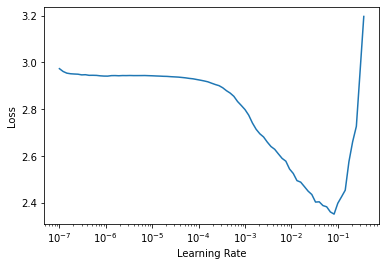

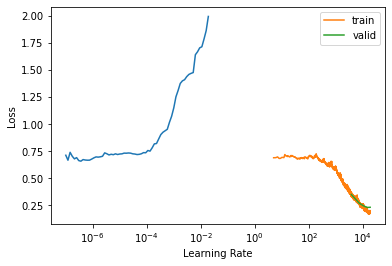

In [41]:
train_learner(learn1)
learn1.save('bert-base-multi')

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.608691,0.566511,0.829878,0.652160,0.602009,0.626082,12:36
1,0.531653,0.495688,0.850264,0.690841,0.648729,0.669123,12:36
2,0.529330,0.487406,0.852623,0.694060,0.653241,0.673032,12:40


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.300729,0.289605,0.918392,0.821403,0.805529,0.813389,17:26
1,0.253211,0.241862,0.932837,0.859661,0.837465,0.848418,17:29
2,0.202410,0.219251,0.940598,0.874104,0.862018,0.868019,17:25
3,0.173180,0.214720,0.943742,0.883997,0.868997,0.876433,17:30
4,0.151836,0.220291,0.944178,0.885889,0.870259,0.878004,17:27


              precision    recall  f1-score   support

         POI       0.93      0.89      0.91     91628
   POI-SHORT       0.89      0.87      0.88     26421
         STR       0.91      0.86      0.88    110110
   STR-SHORT       0.03      0.48      0.06       481

   micro avg       0.89      0.87      0.88    228640
   macro avg       0.69      0.77      0.68    228640
weighted avg       0.91      0.87      0.89    228640



Path('models/indobert-large-p1.pth')

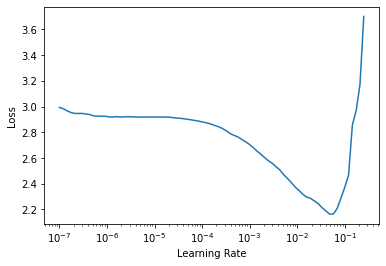

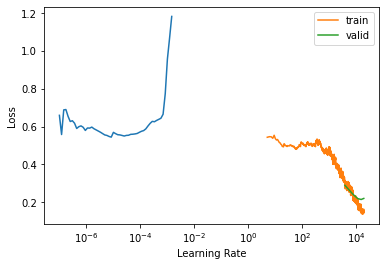

In [42]:
train_learner(learn2)
learn2.save('indobert-large-p1')

# Evaluation
- This is only relevant during model selection and testing
- For the final training, full dataset is used so the accuracy below doesn't really reflect the power of the model.

In [43]:
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None):
    hf_before_batch_tfm = get_blurr_tfm(self.dls.before_batch)

    is_split_str = hf_before_batch_tfm.is_split_into_words and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if (not is_df and (is_split_str or not is_listy(items))): items = [items]
    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp:]

    outs = []
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = [probs[i]]
        item_dec_preds = [decoded_preds[i]]
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])

        outs.append((item_dec_labels, item_dec_preds, item_probs))

    return outs

In [44]:
from string import punctuation

def reconstruct(pred, raw_tokens, raw_address):
    def complete_word(x):
        y = x.strip().strip(punctuation)
        if y != '' and y in wordlist:
            x = x.replace(y, wordlist[y])
        return x
    
    def normalize_bracket(x):
        if '(' in x and ')' not in x:
            x = x + ')'
        elif ')' in x and '(' not in x:
            x = '(' + x
        return x
    
    num = len(pred)
    ans = ['/'] * num
    for idx in tqdm(range(num)):
        res = pred[idx]
        start_poi, end_poi = -1, -1
        start_str, end_str = -1, -1
        for i in range(len(res[0])):
            if 'POI' in res[1][i]:
                if start_poi == -1: start_poi = i
                end_poi = i
            if 'STR' in res[1][i]:
                if start_str == -1: start_str = i
                end_str = i
        
        if start_poi != -1:
            txt1 = raw_address[idx]
            for i in range(start_poi):
                txt1 = txt1[len(raw_tokens[idx][i]):].strip()
            for i in range(len(raw_tokens[idx]) - 1, end_poi, -1):
                txt1 = txt1[:-len(raw_tokens[idx][i])].strip()
            
            txt1_check = ''.join(raw_tokens[idx][start_poi:end_poi + 1]).replace(' ', '')
            assert txt1.replace(' ', '') == txt1_check
            
            last = len(txt1)
            for i in range(end_poi, start_poi - 1, -1):
                while last > 0 and txt1[last - 1] == ' ':
                    last -= 1
                assert last >= len(raw_tokens[idx][i])
                last -= len(raw_tokens[idx][i])
                if 'SHORT' in res[1][i]:
                    txt1 = txt1[:last] + complete_word(raw_tokens[idx][i]) + txt1[last + len(raw_tokens[idx][i]):]
        else:
            txt1 = ''
        
        if start_str != -1:
            txt2 = raw_address[idx]
            for i in range(start_str):
                txt2 = txt2[len(raw_tokens[idx][i]):].strip()
            for i in range(len(raw_tokens[idx]) - 1, end_str, -1):
                txt2 = txt2[:-len(raw_tokens[idx][i])].strip()
            
            txt2_check = ''.join(raw_tokens[idx][start_str:end_str + 1]).replace(' ', '')
            assert txt2.replace(' ', '') == txt2_check
            
            last = len(txt2)
            for i in range(end_str, start_str - 1, -1):
                while last > 0 and txt2[last - 1] == ' ':
                    last -= 1
                assert last >= len(raw_tokens[idx][i])
                last -= len(raw_tokens[idx][i])
                if 'SHORT' in res[1][i]:
                    txt2 = txt2[:last] + complete_word(raw_tokens[idx][i]) + txt2[last + len(raw_tokens[idx][i]):]
        else:
            txt2 = ''
        
        txt1 = txt1.strip(punctuation)
        txt2 = txt2.strip(punctuation)
        txt1 = normalize_bracket(txt1)
        txt2 = normalize_bracket(txt2)
        
        ans[idx] = (txt1 + '/' + txt2)
    
    return ans

In [45]:
def show_diff(df):
    MAX_ROWS = 50
    CNT = 0
    for idx in range(len(df)):
        if CNT == MAX_ROWS: break
        row = df.iloc[idx]
        if row['POI/street'] != row['pred']:
            CNT += 1
            print(idx, row['id'], row['POI/street'], 'vs', row['pred'])

In [46]:
def calc_acc(df):
    return df.loc[test_df['pred'] == df['POI/street'], 'id'].count() / len(df)

In [47]:
raw_tokens = list(test_df['tokens'])
raw_address = list(test_df['raw_address'])

In [48]:
assert list(learn1.dls.vocab) == list(learn2.dls.vocab)

In [49]:
def merge_pred(pred1, pred2):
    assert pred1[0] == pred2[0]
    
    inp = pred1[0]
    probs = pred1[-1] + pred2[-1]
    pred_lbl_ids = probs.argmax(dim=1)
    pred_lbl = learn1.dls.vocab[pred_lbl_ids]
    
    return (inp, pred_lbl, pred_lbl_ids, probs)

In [50]:
raw_pred1 = learn1.blurr_predict_tokens(raw_tokens)
raw_pred2 = learn2.blurr_predict_tokens(raw_tokens)
raw_pred = [merge_pred(x, y) for x, y in zip(raw_pred1, raw_pred2)]

In [51]:
pred1 = reconstruct(raw_pred1, raw_tokens, raw_address)
pred2 = reconstruct(raw_pred2, raw_tokens, raw_address)
pred = reconstruct(raw_pred, raw_tokens, raw_address)

100%|██████████| 45000/45000 [00:00<00:00, 80357.05it/s]


In [52]:
test_df['pred'] = pred1
test_df.head()
calc_acc(test_df)

0.7263111111111111

In [53]:
test_df['pred'] = pred2
test_df.head()
calc_acc(test_df)

0.7435111111111111

In [54]:
test_df['pred'] = pred
test_df.head()
calc_acc(test_df)

0.7417555555555555

In [55]:
show_diff(test_df)

0 90142 / vs /lom
1 163531 / vs varia usaha ungaran/peri kem
3 126157 wardah gorden/srik ton vs wardah goreng/srik ton
5 229731 parfum ila/ vs ila/par
14 211733 /malik ibrahim vs /malik ibra
15 291526 pt. bandung kulina utama/gede bage selatan vs pt. bandung kulkas utama/gede bage sela
18 224230 /raya kertajaya vs /raya kerta
19 36383 sabang merah/ vs taman sabang merah/
21 257507 / vs toko yuni/
22 227444 farlis listrik/jepara- vs farlis listrik/jepara
23 284364 / vs agen sosis bakar om black/
27 14510 / vs fitria jaya taylor/karya
28 19521 /mentor vs /men
30 298204 /puri depok mas vs /puri
31 291158 /poncowati vs /ponco
33 218256 perpustakaan wisma damai/tanjung ged vs perpustakaan wisma damai/tanj ged
34 290927 / vs /raya maluk
39 4009 /rawa sari vs /rawa sari, rawa sari
41 212697 /palem raya vs /palem raya 1
43 288688 bebek harissa & soto w/boulevard vs bebek hariyono & soto w/boule
45 194417 /caw baru ten vs padang/caw baru ten
50 114194 depan lotte mart/jalan kadrie oening vs  de

# Submission

In [56]:
real_test_df = pd.read_csv('data/test.csv')
real_test_df['raw_address'] = real_test_df['raw_address'].apply(lambda x: x.strip())
real_test_df['tokens'] = real_test_df['raw_address'].apply(clean).str.split()
real_test_df.head()

,id,raw_address,tokens
0,0,s. par 53 sidanegara 4 cilacap tengah,"[s., par, 53, sidanegara, 4, cilacap, tengah]"
1,1,"angg per, baloi indah kel. lubuk baja","[angg, per,, baloi, indah, kel., lubuk, baja]"
2,2,"asma laun, mand imog,","[asma, laun,, mand, imog,]"
3,3,"ud agung rej, raya nga sri wedari karanganyar","[ud, agung, rej,, raya, nga, sri, wedari, karanganyar]"
4,4,"cut mutia, 35 baiturrahman","[cut, mutia,, 35, baiturrahman]"


In [57]:
raw_tokens = list(real_test_df['tokens'])
raw_address = list(real_test_df['raw_address'])

In [58]:
raw_pred1 = learn1.blurr_predict_tokens(raw_tokens)
raw_pred2 = learn2.blurr_predict_tokens(raw_tokens)
raw_pred = [merge_pred(x, y) for x, y in zip(raw_pred1, raw_pred2)]

In [59]:
pred1 = reconstruct(raw_pred1, raw_tokens, raw_address)
pred2 = reconstruct(raw_pred2, raw_tokens, raw_address)
pred = reconstruct(raw_pred, raw_tokens, raw_address)

100%|██████████| 50000/50000 [00:00<00:00, 81274.19it/s]


In [60]:
real_test_df['POI/street'] = pred

In [61]:
real_test_df.drop(columns=['raw_address', 'tokens'], inplace=True)
real_test_df.head()

,id,POI/street
0,0,/s. par
1,1,/angg per
2,2,asma laundry/mand imog
3,3,ud agung rejeki/raya nga
4,4,/cut mutia


In [62]:
real_test_df.to_csv('submission.csv', index=False)